<a href="https://colab.research.google.com/github/andrehochuli/teaching/blob/main/ComputerVision/Lecture%2007%20-%20CNN%20Implementation/Lecture_07_CNN_Archicteture-LectureNotes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import cv2, glob
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import datasets, layers, models, losses
from tensorflow.keras.models import Model
from sklearn import metrics

#To ensure reproducibility
#we set the random seed
seed_number = 42
tf.random.set_seed(seed_number)
np.random.seed(seed_number)


In [ ]:
#Auxiliary Function to plot side by side
#@Author: Prof. André Hochuli
#Visualiza um lista de figuras lado a lado, facilitando a comparação qualitativa
def plot_sidebyside(img_list,titles=None,colormap=None,figsize=(12,6)):
  n = len(img_list)
  figure, axis = plt.subplots(1, n, figsize=figsize)

  if titles is None:
    titles = []
    A = ord('A')
    for i in range(n):
      titles.append(chr(A+i))

  for i in range(n):
    axis[i].imshow(img_list[i], cmap=colormap)
    axis[i].set_title(titles[i])
    axis[i].axis('off')
  # Combine all the operations and display
  plt.show()

In [ ]:
#@Author: Prof. André Hochuli
#Compila os resultados para analises qualitativas e quantitativas
def performance_evaluation(x_test, y_test, predictions, class_names, info_message):

    print(f"Evaluation of {info_message}")
    print(metrics.classification_report(y_test, predictions))


    # Matriz de confusão
    disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, predictions)
    disp.figure_.suptitle("Confusion Matrix")
    plt.show()

    # Imagens classificadas corretamente
    correct_idx = np.where(y_test == predictions)[0]
    n_correct = min(10, len(correct_idx))
    if n_correct > 0:
        plt.figure(figsize=(22, 4))
        for i in range(n_correct):
            idx = correct_idx[i]
            plt.subplot(1, n_correct, i+1)
            plt.imshow(x_test[idx], cmap='gray', interpolation='nearest')
            plt.axis('off')
            plt.title(f"Lbl:{y_test[idx]} Pred:{predictions[idx]}")
        plt.suptitle("Correct Predictions", fontsize=16, fontweight='bold', color='white', backgroundcolor='green')
        plt.show()

    #Imagens classificadas incorretamente
    wrong_idx = np.where(y_test != predictions)[0]
    n_wrong = min(10, len(wrong_idx))
    if n_wrong > 0:
        plt.figure(figsize=(22, 4))
        for i in range(n_wrong):
            idx = wrong_idx[i]
            plt.subplot(1, n_wrong, i+1)
            plt.imshow(x_test[idx], cmap='gray', interpolation='nearest')
            plt.axis('off')
            plt.title(f"Lbl:{y_test[idx]} Pred:{predictions[idx]}")
        plt.suptitle("Wrong Predictions", fontsize=16, fontweight='bold', color='white', backgroundcolor='red')
        plt.show()


    #Exibir exemplo de cada classe
    unique_classes = np.unique(y_test)
    plt.figure(figsize=(22, 4))
    for i, cls in enumerate(unique_classes):
        idx = np.where(y_test == cls)[0][0]  # primeiro índice da classe
        plt.subplot(1, len(unique_classes), i+1)
        plt.imshow(x_test[idx], cmap='gray', interpolation='nearest')
        plt.axis('off')
        plt.title(f"{i}-{class_names[cls]}")
    plt.suptitle("Example of each class", fontsize=16, fontweight='bold', color='black', backgroundcolor='yellow')
    plt.show()


In [ ]:
#Plot dataset samples
def plot_dataset(ds, lbls_name):
  N_SAMPLES = 10
  for i in range(5):
    for x,y in ds.take(1):

      x = x.numpy()
      x = np.squeeze(x)
      y = y.numpy()
      plot_sidebyside(x[:N_SAMPLES],
                      y[:N_SAMPLES],'gray')

#Plot a training history
def plot_history(history):
  print(history.history.keys())
  # summarize history for accuracy
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()


# Datasets (from scratch)

In [ ]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
!wget $dataset_url -O flower_photos.tgz


In [ ]:
!tar -xzf flower_photos.tgz
!ls flower_photos/

image_count = len(list(glob.glob('flower_photos/*/*.jpg')))
print(f'The dataset has {image_count} images')

#Holdout

In [ ]:
import os
import shutil
import random

# Paths
source_dir = "flower_photos"
holdout_dir = "flower_photos_holdout"
splits = {"train": 0.7, "test": 0.30}
classes = [d for d in os.listdir(source_dir) if os.path.isdir(os.path.join(source_dir, d))]

# Create folders
for split in splits:
    for cls in classes:
        os.makedirs(os.path.join(holdout_dir, split, cls), exist_ok=True)

# Distribute images
for cls in classes:
    cls_files = os.listdir(os.path.join(source_dir, cls))
    random.shuffle(cls_files)
    n_total = len(cls_files)
    n_train = int(splits["train"] * n_total)


    for i, file in enumerate(cls_files):
        if i < n_train:
            split = "train"
        else:
            split = "test"

        src_path = os.path.join(source_dir, cls, file)
        dst_path = os.path.join(holdout_dir, split, cls, file)
        shutil.copy(src_path, dst_path)


#Tensorflow Dataset Pipeline

In [ ]:
batch_size_ = 64
input_shape_ = (96,96,3)

train_ds = tf.keras.utils.image_dataset_from_directory(
  holdout_dir + "/train",
  validation_split=0.2,
  subset="training",
  seed=seed_number,
  image_size=(input_shape_[0], input_shape_[1]),
  batch_size=batch_size_)

val_ds = tf.keras.utils.image_dataset_from_directory(
  holdout_dir + "/train",
  validation_split=0.2,
  subset="validation",
  seed=seed_number,
  image_size=(input_shape_[0], input_shape_[1]),
  batch_size=batch_size_)


test_ds = tf.keras.utils.image_dataset_from_directory(
  holdout_dir + "/test",
  seed=seed_number,
  image_size=(input_shape_[0], input_shape_[1]),
  batch_size=batch_size_)

class_names = train_ds.class_names
print(class_names)

#Dataset Visualization

In [ ]:
class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)
class_names = np.array(class_names)
for img,lbl in train_ds.take(5):
  print(img.shape)
  titles = []
  for i in lbl:
    titles.append(class_names[lbl[i]])

  plot_sidebyside(img[:5]/255.,titles[:5])

#CNN From Scratch

#The Convolutional Layers
  As stated in the last class, a cnn model enqueue several convolutional layers. This step is called 'feature extraction'. In the end of this structure, the resulting matrix is a feature map with dense representations

  Lets see how to code it!

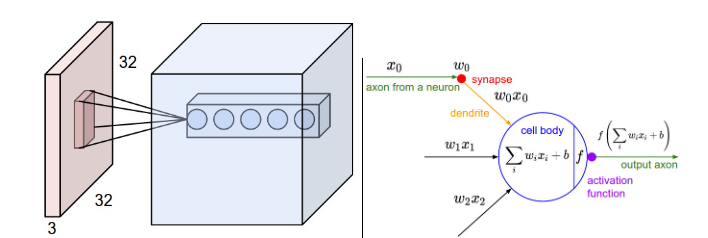


Additional Reference: https://cs231n.github.io/convolutional-networks/

To better illustrate, lets visualize a 6-layer CNN

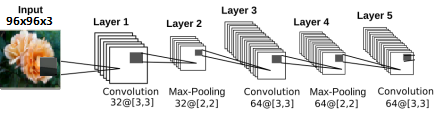

The respective implementation follows:




In [ ]:
def create_model():
  model = models.Sequential()

  model.add(layers.InputLayer(input_shape=input_shape_))

  #scales pixel values to [0,1], preventing and improving numerical stability during training.
  model.add(layers.Rescaling(1./255))

  #32 layers of size 3x3 and Relu Activation
  model.add(layers.Conv2D(32, (3, 3), activation='relu'))

  #Max Pooling of Size (2x2)
  model.add(layers.MaxPooling2D((2, 2)))


  #64 layers of size 3x3 and Relu Activation
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))

  #Max Pooling of Size (2x2)
  model.add(layers.MaxPooling2D((2, 2)))

  #64 layers of size 3x3 and Relu Activation
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))

  #Max Pooling of Size (2x2)
  model.add(layers.MaxPooling2D((2, 2)))

  return model

model = create_model()
model.summary()

#The Fully Connected Layer
  The fully connected layer (FC) is a dense layer that receives a 1D tensor. It will provide predictions and probabilities. This is the classification step in the pipeline and can be replaced for another model. (SVM, etc.)

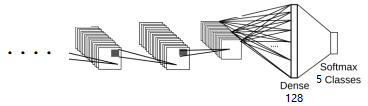

The last layer is a softmax activation

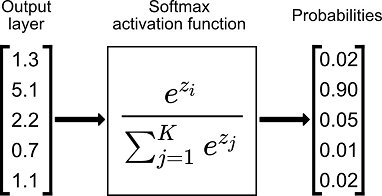

In [ ]:
model.add(layers.Flatten())

model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(num_classes,activation='softmax'))

model.summary()

#Training

In [ ]:
epochs_ = 20
model.compile(optimizer="Adam", loss="sparse_categorical_crossentropy", metrics=["acc"])
history = model.fit(train_ds, batch_size=batch_size_, epochs=epochs_, validation_data=val_ds)

In [ ]:
model.save_weights("model.weights.h5")

#Evaluation

In [ ]:
plot_history(history)

In [ ]:
x_test_list, y_test_list = [], []

for images, labels in test_ds:
    x_test_list.append(images.numpy())  # convert tensor to numpy
    y_test_list.append(labels.numpy())

# concatenate all batches
x_test = np.concatenate(x_test_list, axis=0)
y_test = np.concatenate(y_test_list, axis=0)



In [ ]:
predictions = model.predict(x_test)
predictions = np.argmax(predictions, axis = 1)
print(x_test.shape, y_test.shape, predictions.shape)


performance_evaluation(x_test/255.,y_test, predictions,class_names,"CNN Predictions")


#Overfitting

Overfitting occurs when a model captures noise or specific patterns in the training data, impairing its ability to generalize to unseen data. Strategies such as regularization, dropout, data augmentation, and transfer learning help mitigate this by controlling model complexity and leveraging pre-learned features.

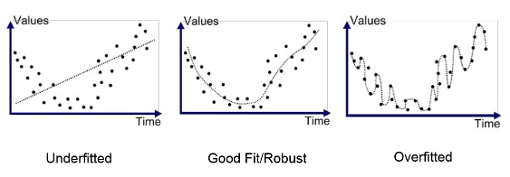

##Data augmentation
Data augmentation is a technique that artificially increases the size and diversity of a dataset by applying transformations such as rotation, flipping, cropping, or color adjustments. It helps improve model generalization, reduces overfitting, and is especially useful when training data is limited.

In [ ]:
from tensorflow.keras import Sequential

data_aug = Sequential([

    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomTranslation(0.1, 0.1),
    layers.RandomContrast(0.2),
    layers.RandomBrightness(factor=0.2)
])

In [ ]:
for imgs, labels in train_ds.take(1):
    image = imgs[0]   # primeira imagem do batch
    plt.figure(figsize=(10, 10))

    # Plot da imagem original
    plt.subplot(4, 3, 1)
    plt.imshow(image.numpy().astype("uint8"))
    plt.title("Original")
    plt.axis("off")

    # Plots das augmentations
    for i in range(11):
        aug_img = data_aug(tf.expand_dims(image, 0))
        plt.subplot(4, 3, i+2)  # começa da posição 2
        plt.imshow(aug_img[0].numpy().astype("uint8"))
        plt.axis("off")

    plt.suptitle("Original + Augmentations", fontsize=16)
    plt.tight_layout()
    plt.show()

##Dropout

Dropout is a regularization technique that randomly deactivates a fraction of neurons during training, forcing the model to learn redundant representations and reducing overfitting.

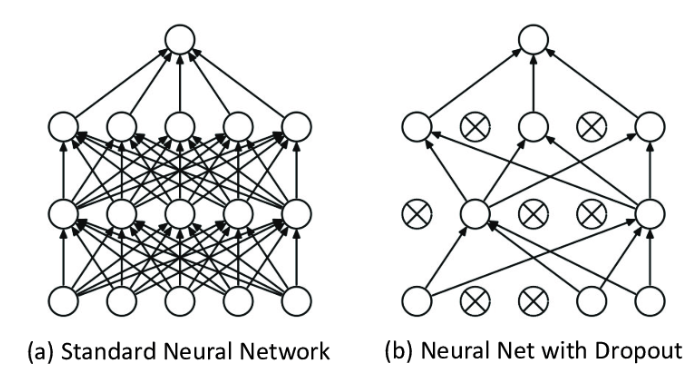

In [ ]:
def create_model_aug():
    model = models.Sequential()

    model.add(layers.InputLayer(input_shape=input_shape_))

    #Augmentation "online"
    model.add(data_aug)

    #scales pixel values to [0,1], preventing and improving numerical stability during training.
    model.add(layers.Rescaling(1./255))

    #32 layers of size 3x3 and Relu Activation
    model.add(layers.Conv2D(32, (3, 3), activation='relu'))

    #Max Pooling of Size (2x2)
    model.add(layers.MaxPooling2D((2, 2)))

    #64 layers of size 3x3 and Relu Activation
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))

    #Max Pooling of Size (2x2)
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(64, (3, 3), activation='relu'))

    #Max Pooling of Size (2x2)
    model.add(layers.MaxPooling2D((2, 2)))

    #Adding a Dropout Layer
    model.add(layers.Dropout(0.25))


    #Classification
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dropout(0.25))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.25))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(num_classes,activation='softmax'))

    return model

In [ ]:
model = create_model_aug()
model.summary()
epochs_ = 50
model.compile(optimizer="Adam", loss="sparse_categorical_crossentropy", metrics=["acc"])
history = model.fit(train_ds, batch_size=batch_size_, epochs=epochs_, validation_data=val_ds)

In [ ]:
plot_history(history)

#Save and Load Weights

Save and load weights allows storing a model’s learned parameters to disk and reloading them later. This enables resuming training, sharing models, or deploying them without retraining, ensuring reproducibility and efficiency.

In [ ]:
model.save_weights("model.weights.h5")

In [ ]:
model = create_model_aug()
predictions = model.predict(x_test)
predictions = np.argmax(predictions, axis = 1)

print(metrics.classification_report(y_test, predictions, target_names=class_names))

In [ ]:
model.load_weights("model.weights.h5")
predictions = model.predict(x_test)
predictions = np.argmax(predictions, axis = 1)

print(metrics.classification_report(y_test, predictions, target_names=class_names))

#Resuming Training

In [ ]:
model.load_weights("model.weights.h5")

model.compile(optimizer="Adam", loss="sparse_categorical_crossentropy", metrics=["acc"])

epochs_ = 10
history = model.fit(train_ds, batch_size=batch_size_, epochs=epochs_, validation_data=val_ds)

#Checkpoints and EalyStopping

Checkpoints save a model’s weights during training, typically at the end of each epoch or when performance improves, allowing recovery in case of interruptions and ensuring the best model is retained.

Early stopping monitors a validation metric and halts training when improvement stops, preventing overfitting by avoiding unnecessary epochs. Together, they help maintain model performance and stability.

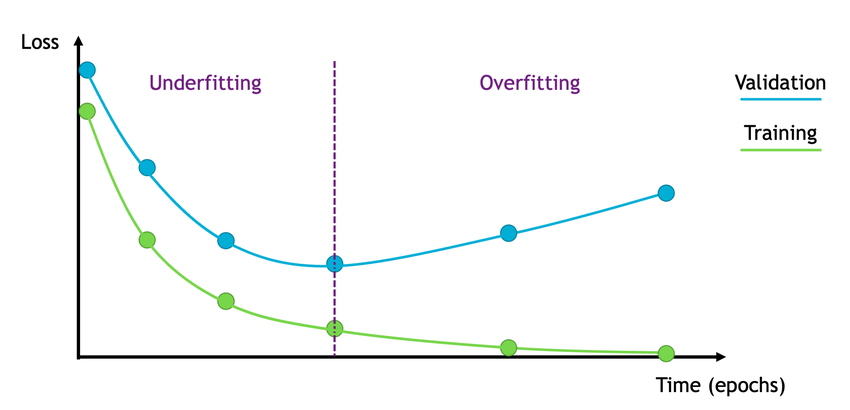

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Salvar o melhor modelo baseado na métrica de validação
checkpoint_cb = ModelCheckpoint(
    #"{epoch:02d}-{val_loss:.2f}.weights.h5",
    "best.weights.h5",
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=False,
    verbose=1
)


In [ ]:
model = create_model_aug()

model.compile(optimizer="Adam", loss="sparse_categorical_crossentropy", metrics=["acc"])


epochs_ = 30
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs_,
    callbacks=[checkpoint_cb, early_stop]
)

#Transfer-Learning

Transfer learning is a technique where a model pre-trained on a large dataset is adapted to a new task, often with less data. By leveraging previously learned features, it reduces training time, improves performance, and helps prevent overfitting on smaller datasets.

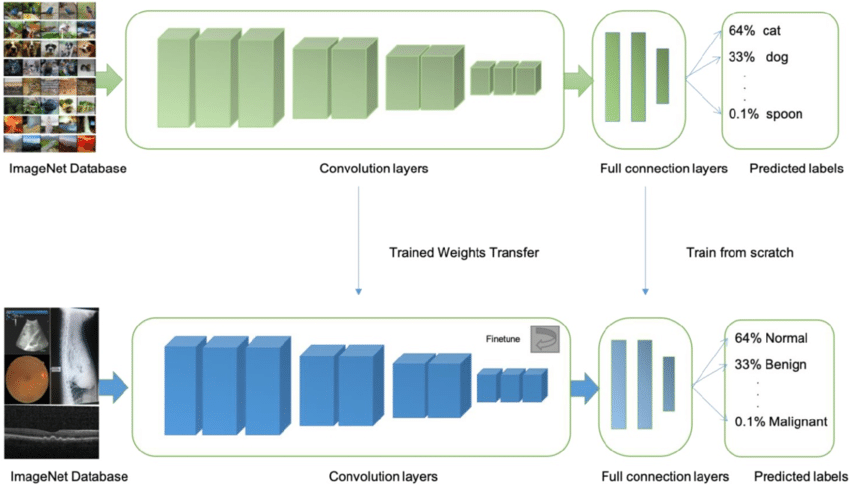

In [ ]:
preprocess_function = tf.keras.applications.mobilenet.preprocess_input
model_function = tf.keras.applications.MobileNetV2

#preprocess_function = tf.keras.applications.resnet.preprocess_input
#model_function = tf.keras.applications.ResNet50

base_model = model_function(
    input_shape=input_shape_,
    include_top=False,
    weights="imagenet"
)

base_model.trainable = False  # congela as camadas da base


inputs = layers.Input(shape=input_shape_)
x = data_aug(inputs)
x = layers.Lambda(preprocess_function)(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)     # pooling global (flatten)
x = layers.Dropout(0.3)(x)

#classifier
x = layers.Dense(512, activation="relu")(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dense(128, activation="relu")(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model = Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

In [ ]:
checkpoint_cb = ModelCheckpoint(
    #"{epoch:02d}-{val_loss:.2f}.weights.h5",
    "best.weights.h5",
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=False,
    verbose=1
)

epochs_ = 100
model.compile(optimizer="Adam", loss="sparse_categorical_crossentropy", metrics=["acc"])
history = model.fit(train_ds, batch_size=batch_size_, epochs=epochs_, validation_data=val_ds, callbacks=[checkpoint_cb,early_stop])

In [ ]:
model.save_weights("last.weights.h5")

In [ ]:
plot_history(history)

In [ ]:
model.load_weights("best.weights.h5")
predictions = model.predict(x_test)
predictions = np.argmax(predictions, axis = 1)

print(metrics.classification_report(y_test, predictions, target_names=class_names))

In [ ]:
model.load_weights("last.weights.h5")
predictions = model.predict(x_test)
predictions = np.argmax(predictions, axis = 1)

print(metrics.classification_report(y_test, predictions, target_names=class_names))